In [9]:
import os
import netket as nk
from netket.operator.spin import sigmax, sigmaz, sigmay
from src.models import * 
import matplotlib.pyplot as plt
import numpy as np
import flax

## Parameters

In [2]:
L = 3

note hilbert space is on edges
there is no natural ordering to the hilbert space so we will have to impose one.
this is specified by wilson.ordered_edges.
as long as we respect this ordering across all implementations, things should work. Convention is vertical links first.

In [3]:
g = nk.graph.Square(L, pbc=True)
print(f'g.n_edges = {g.n_edges}, LxLx2 = {L**2 * 2}')
hi = nk.hilbert.Spin(s=1/2, N=g.n_edges)

g.n_edges = 18, LxLx2 = 18


The Z_2 gauge theory Hamiltonian is 
$$
H = -K \sum_{\square} \prod_{ij \in \square} \sigma_{ij}^z - g \prod_{ij} \sigma_{ij}^x
$$

In [4]:
def z2_hamiltonian(theta, g, hi):
	h = 0
	edges = ordered_edges(g)

	for i in g.nodes(): 
		l, r, u, d = plaquette_indices(i, L)
		h += - np.cos(theta) * sigmaz(hi, l) * sigmaz(hi, d) * sigmaz(hi, r) * sigmaz(hi, u)

	for i in range(g.n_edges):
		h += - np.sin(theta) * sigmax(hi, i)

	return h

## Vary parameters and verify against ED 

In [5]:
thetas = np.linspace(0, np.pi/2, 10)
exact_energies = [] 
genn_energies = []
genn_energies_var = []

i = 1
for theta in thetas:
	print(f'{i}/{len(thetas)}')

	h = z2_hamiltonian(theta, g, hi)
	exact_energy = nk.exact.lanczos_ed(h)
	print(f'exact energy:\t{exact_energy}')

	genn = GENN(graph=g)
	sampler = nk.sampler.MetropolisLocal(hi)
	vstate = nk.vqs.MCState(sampler, model=genn, n_samples=1008)
	optimizer = nk.optimizer.Sgd(learning_rate=0.05)
	preconditioner = nk.optimizer.SR(diag_shift=0.1, holomorphic=False)
	vmc = nk.driver.VMC(h, optimizer, variational_state=vstate, preconditioner=preconditioner)
	log = nk.logging.RuntimeLog()
	vmc.run(n_iter=500, out=log)
	
	genn_energy = vstate.expect(h)
	
	exact_energies.append(exact_energy)
	genn_energies.append(genn_energy.mean.real)
	genn_energies_var.append(genn_energy.variance)
	i += 1

1/10
exact energy:	[-9.]


KeyboardInterrupt: 

In [ ]:
genn_energies = np.array(genn_energies)
genn_energies_var = np.array(genn_energies_var)
thetas = np.array(thetas)
exact_energies = np.array(exact_energies)

In [ ]:
# np.savetxt(f'../data/z2_varying_h_{L}x{L}.txt', np.column_stack((thetas, exact_energies, genn_energies, genn_energies_var)))

## Deconfined Phase

In [5]:
L = 10

In [15]:
g = nk.graph.Square(L, pbc=True)
print(f'g.n_edges = {g.n_edges}, LxLx2 = {L**2 * 2}')
hi = nk.hilbert.Spin(s=1/2, N=g.n_edges)

g.n_edges = 200, LxLx2 = 200


In [16]:
h_deconfined = z2_hamiltonian(np.pi/8, g, hi)

genn = GENN(graph=g)
sampler = nk.sampler.MetropolisLocal(hi)
deconf_vstate = nk.vqs.MCState(sampler, model=genn, n_samples=1008)
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
preconditioner = nk.optimizer.SR(diag_shift=0.1, holomorphic=False)
vmc = nk.driver.VMC(h_deconfined, optimizer, variational_state=deconf_vstate, preconditioner=preconditioner)
log = nk.logging.RuntimeLog()
vmc.run(n_iter=250, out=log)

100%|██████████| 250/250 [08:09<00:00,  1.96s/it, Energy=-104.540-0.000j ± 0.070 [σ²=4.954, R̂=1.0106]]


(RuntimeLog():
  keys = ['Energy'],)

In [17]:
with open("../data/z2_deconfine.mpack", 'wb') as file:
  file.write(flax.serialization.to_bytes(deconf_vstate))

In [18]:
from src.wilson import wilson_loop_indices
from tqdm import tqdm

wloops_means = []
wloops_vars  = []
for l in tqdm(range(1, L- 3)):
	indices = wilson_loop_indices(l, L)
	wilson_loop = 1 
	for i in indices: 
		wilson_loop = wilson_loop * sigmaz(hi, i)

	wl = deconf_vstate.expect(wilson_loop)
	wloops_means.append(wl.mean.real)
	wloops_means.append(wl.variance)


100%|██████████| 6/6 [03:07<00:00, 31.26s/it]


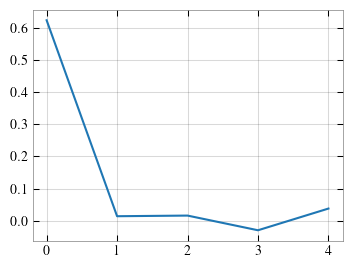

In [32]:
wloops_even = [wloops_means[2*i] for i in range(L//2)]
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(wloops_even)
# ax.set_yscale('log')